In this notebook we check the effects of updating the skybrightness from the old opsim v3 model to the new [sims_skybrightness model](https://github.com/lsst/sims_skybrightness).

In short: the new model is based on ESO sky brightness estimates, with an additional twilight component. The old model is based on [Krisciunas & Schaefer 1991](http://adsabs.harvard.edu/full/1991PASP..103.1033K), with additional lunar-phase-dependent color-terms per filter. The old model had no twilight or y band estimates, instead setting a constant skybrightness of 17.5 during twilight and in y band.

We reprocessed minion_1016 (the latest v3 baseline, created with the old skybrightness model) to add new skybrightness values based on sims_skybrightness. We also updated the resulting FiveSigmaDepths. 

The skybrightness and limiting magnitudes will be the only changes as a result of this reprocessing; the intent here is to evaluate the impact of these updates. New v4 runs will be comparable to the newer skybrightness and limiting magnitude values.

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.plots as plots
import lsst.sims.maf.runComparison as rc

In [3]:
# Set some parameters - where to read the data, what runs to use, colors to use in plots.
rootdir = '.'
runlist = ['minion_1016_oldsky', 'minion_1016_newsky']
colors = {'minion_1016_oldsky': 'b', 'minion_1016_newsky': 'r'}
# Set up the RunComparison and connect to the resultsDatabases for each run.
comp = rc.RunComparison(baseDir=rootdir, runlist=runlist)

In [4]:
# Check which analysis results are available.
for r in comp.runlist:
    print(r, comp.runresults[r].keys())

minion_1016_oldsky dict_keys(['sci', 'all', 'sched', 'srd'])
minion_1016_newsky dict_keys(['sci', 'all', 'sched', 'srd'])


In [5]:
# Read in all summary metrics, from all of these analysis.
mdicts = comp.buildMetricDict()
# Suppress warnings from metrics which do not have summary stats. 
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    comp.addSummaryStats(mdicts)

In [6]:
print('This has pulled out %d summary stats. ' % len(comp.summaryStats.columns))
print('Some (for now) might be duplicates: example the fO metrics:')
cols = [c for c in comp.summaryStats.columns if ('fO' in c) and ('WFD' in c)]
comp.summaryStats[cols]

This has pulled out 9110 summary stats. 
Some (for now) might be duplicates: example the fO metrics:


,fOArea: Nvisits (#) fO WFD only (non-dithered) HealpixSlicer,fOArea: Nvisits/benchmark fO WFD only (non-dithered) HealpixSlicer,fONv: Area (sqdeg) fO WFD only (non-dithered) HealpixSlicer,fONv: Area/benchmark fO WFD only (non-dithered) HealpixSlicer,fOArea: Nvisits (#) fO WFD HealpixSlicer,fOArea: Nvisits/benchmark fO WFD HealpixSlicer,fONv: Area (sqdeg) fO WFD HealpixSlicer,fONv: Area/benchmark fO WFD HealpixSlicer
minion_1016_oldsky,888.0,1.076364,18040.616904,1.002256,888.0,1.076364,18040.616904,1.002256
minion_1016_newsky,888.0,1.076364,18040.616904,1.002256,888.0,1.076364,18040.616904,1.002256


Normalize the summary stats by the old sky version, and look for outliers.
The normalized version of the stats shows the percent change from the baseline.

In [7]:
comp.normalizeStats(baselineRun='minion_1016_oldsky')
comp.normalizedStats[cols]

,fOArea: Nvisits (#) fO WFD only (non-dithered) HealpixSlicer,fOArea: Nvisits/benchmark fO WFD only (non-dithered) HealpixSlicer,fONv: Area (sqdeg) fO WFD only (non-dithered) HealpixSlicer,fONv: Area/benchmark fO WFD only (non-dithered) HealpixSlicer,fOArea: Nvisits (#) fO WFD HealpixSlicer,fOArea: Nvisits/benchmark fO WFD HealpixSlicer,fONv: Area (sqdeg) fO WFD HealpixSlicer,fONv: Area/benchmark fO WFD HealpixSlicer
minion_1016_oldsky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
minion_1016_newsky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Look for stats which change more than 2% - since we don't really expect any changes. 
df = comp.normalizedStats
changecols = []
for i in comp.normalizedStats.columns:
    if df[i].max() > 0.02:
        changecols.append(i)
    if df[i].min() < -0.02: 
        changecols.append(i)

In [9]:
# Which stats changed? Should be skybrightness, limiting magnitude, and values which depend on these quantities.
len(changecols), changecols

(1006,
 ['25th%ile Parallax Coverage 20 All Visits (non-dithered) HealpixSlicer',
  'Min Parallax Coverage 24 All Visits (non-dithered) HealpixSlicer',
  '25th%ile Parallax-DCR degeneracy 24 All Visits (non-dithered) HealpixSlicer',
  '75th%ile Parallax-DCR degeneracy 24 All Visits (non-dithered) HealpixSlicer',
  'Max Parallax-DCR degeneracy 24 All Visits (non-dithered) HealpixSlicer',
  'Mean Parallax-DCR degeneracy 24 All Visits (non-dithered) HealpixSlicer',
  'Median Parallax-DCR degeneracy 24 All Visits (non-dithered) HealpixSlicer',
  'Min Parallax-DCR degeneracy 24 All Visits (non-dithered) HealpixSlicer',
  'RobustRms Parallax-DCR degeneracy 24 All Visits (non-dithered) HealpixSlicer',
  '25th%ile Parallax 24 All Visits (non-dithered) HealpixSlicer',
  '75th%ile Parallax 24 All Visits (non-dithered) HealpixSlicer',
  'Max Parallax 24 All Visits (non-dithered) HealpixSlicer',
  'Mean Parallax 24 All Visits (non-dithered) HealpixSlicer',
  'Min Parallax 24 All Visits (non-dither

So first let's look at the actual skybrightness changes, for all observations. 

Loop through filters and plot observed skybrightness.

skyBrightness Histogram All props u band OneDSlicer 1
skyBrightness Histogram All props g band OneDSlicer 2
skyBrightness Histogram All props r band OneDSlicer 3
skyBrightness Histogram All props i band OneDSlicer 4
skyBrightness Histogram All props z band OneDSlicer 5
skyBrightness Histogram All props y band OneDSlicer 6


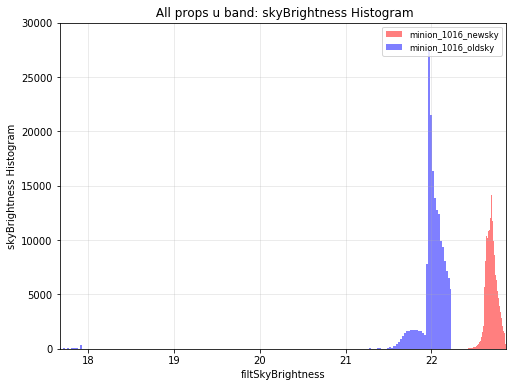

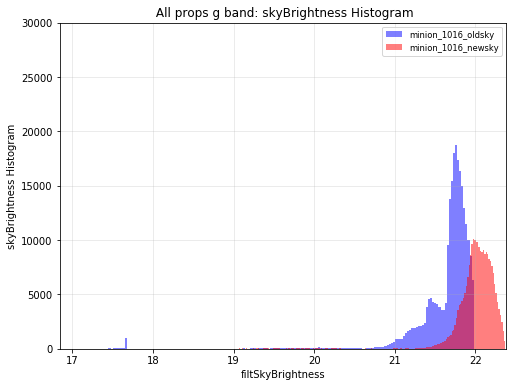

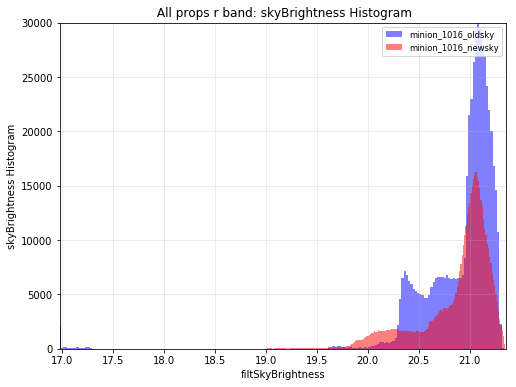

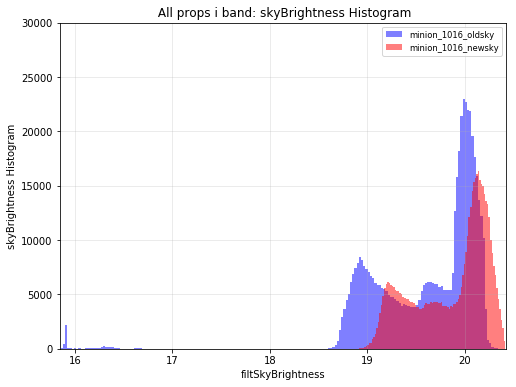

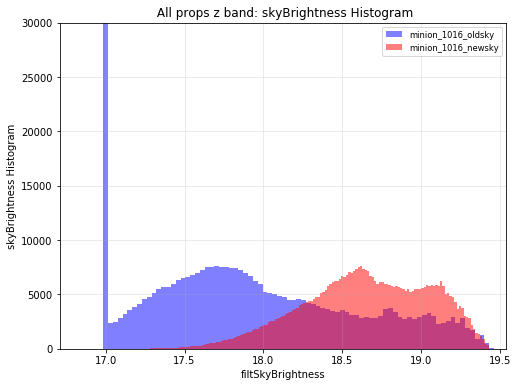

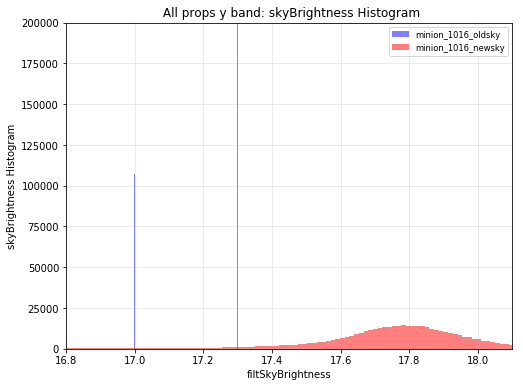

In [10]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
skybright = {}
for f in filterlist:
    mdict = comp.buildMetricDict(metricNameLike='skyBrightness', metricMetadataLike='All props %s' % f, 
                                 slicerNameLike='OneDSlicer')
    for m in mdict:
        skybright[f], mname = comp.readMetricData(**mdict[m])
        print(mname, len(skybright))
        for r in runlist:
            colordict = {'color': colors[r]}
            skybright[f][r].setPlotDict(colordict)
        userPlotDict = {'yMin': 0, 'yMax': 30000, 'filled': True, 'figsize': (8, 6), 'grid': True}
        if f == 'y':
            userPlotDict['xMin'] = 16.8
            userPlotDict['xMax'] = 18.1
            userPlotDict['yMax'] = 200000
        comp.plotMetricData(skybright[f], plotFunc=plots.OneDBinnedData(), userPlotDict=userPlotDict)